In this lab, we will practice:
1. Capturing pictures from the webcam;
2. Object detection on the captured picture, with pre-trained model;

In [ ]:
# Pip install method (recommended)

!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

Ultralytics YOLOv8.0.20 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.8/107.7 GB disk)


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

## Captureing pictures from the webcam

Here are the functions to capture a photo from the webcam on your device.
You're free to use them, or create your own version.

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      // const stream = await navigator.mediaDevices.getUserMedia({video: true});

      const devices = await navigator.mediaDevices.enumerateDevices();
      // Find the ID of the second webcam (if available)
      let secondWebcamId;
      for (const device of devices) {
        if (device.kind === 'videoinput') {
          if (!secondWebcamId) {
            secondWebcamId = device.deviceId;
          }
        }
      }

      if (secondWebcamId) {
        const stream = await navigator.mediaDevices.getUserMedia({ video: { deviceId: { exact: secondWebcamId } } });
      } else {
        // Handle the case where a second webcam is not available.
        console.error('Second webcam not found.');
      }
      const stream = await navigator.mediaDevices.getUserMedia({ video: { deviceId: { exact: secondWebcamId } } });
      // const stream = await navigator.mediaDevices.getUserMedia({video: { deviceId: { exact: devices[0].deviceId } }});


      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

Run the following code block, the streaming video is on from the webcam until you hit the "capture" button to take a screenshot.
You may want to modify the code, to save the photo to a specific directory, with a specific filename (i.e. {HOME}/screenshots/photo_i.jpg)

In [ ]:
try:
  filename = take_photo('photo2.jpg')
  print('Saved to {HOME}/screenshots/photo_i.jpg}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))


  from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

'HOME'


##Object detection on the captured picture, with pre-trained model;

Object detection on new photos uses similar code as you did inference in the previous lab.

Suppose you have images 'newPhotos/image1.jpg', 'newPhotos/image2.jpg', you can either have source=newPhotos/image1.jpg to predict on a single image, or source=newPhotos to predict on all images in the directory.

Note: The code below assumes you have your pre-trained model saved in {HOME}/runs/detect/train2/weights/best.pt. This 'best.pt' file is generated from your model training in the previous lab, but may not still exist right now. To avoid training the model every time, you want to copy this file to your Google Drive, and reuse it next time. To copy file1 to file2, use command '!cp file1 file2`. You want to refer previous labs on how to connect your Google Drive with the notebook.

In [ ]:
%cd {HOME}
!yolo task=detect mode=predict model=/content/drive/MyDriveColab Notebooks/Lab11/best.pt conf=0.25 source=photo2.jpg save=True

# !yolo task=detect mode=predict model={HOME}/runs/detect/train2/weights/best.pt conf=0.25 source=newPhotos save=True

/content
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/cfg/__init__.py", line 212, in entrypoint
    raise argument_error(a)
SyntaxError: 'Notebooks/Lab11/best.pt' is not a valid YOLO argument.

    YOLOv8 'yolo' CLI commands use the following syntax:

        yolo TASK MODE ARGS

        Where   TASK (optional) is one of [detect, segment, classify]
                MODE (required) is one of [train, val, predict, export]
                ARGS (optional) are any number of custom 'arg=value' pairs like 'imgsz=320' that override defaults.
                    See all ARGS at https://docs.ultralytics.com/cfg or with 'yolo cfg'

    1. Train a detection model for 10 epochs with an initial learning_rate of 0.01
        yolo detect train data=coco128.yaml model=yolov8n.pt epochs=10 lr0=0.01

    2. Predict a YouTube video using a pretrained segmentation model at imag

After prediction, the log should say something like "Results saved to runs/detect/predict4'. You can view the results with the following code.

In [ ]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict2/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

## Instruction for the final demo


For the final demo we will do:
- Take photos with the webcam and save them in a specific directory.
- Load your pre-trained model, do inference on the images saved.
- Display the inference results.

Each team will need to complete 20 tasks (images) within 10 minutes. Please prepare your code to automate the process above.

Please submit your ipynb file on Canvas at the end of the demo.

In [ ]:
# Here is an example


## Create a directory to save pictures.
!mkdir /content/drive/MyDrive/0_TA_ECEN250_2024_Spring/Project/Images

## This removes all existing images in this directory.
!rm /content/drive/MyDrive/0_TA_ECEN250_2024_Spring/Project/Images/*.jpg

## Using a for-loop to take multiple pictures.
## Adjust numPictures as needed.
numPictures = 1

for i in range(numPictures):
  ## "format(i, '02d')" converts i to a string,  leading 0 in the format signifies 0-padding, the 2 is the minimal field width.
  fileNameStr = '/content/drive/MyDrive/g/Project/Images' + '/photo_' + format(i, '02d') + '.jpg'
  # print(fileNameStr)
  try:

    filename = take_photo(fileNameStr)
    print('Saved to {}'.format(filename))

    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))

mkdir: cannot create directory ‘/content/drive/MyDrive/0_TA_ECEN250_2024_Spring/Project/Images’: File exists
rm: cannot remove '/content/drive/MyDrive/0_TA_ECEN250_2024_Spring/Project/Images/*.jpg': No such file or directory


<IPython.core.display.Javascript object>

In [ ]:
## Do object detection with the images above
%cd {HOME}
!yolo task=detect mode=predict model=/content/drive/MyDrive/0_TA_ECEN250_2024_Spring/Project/best.pt conf=0.25 source=/content/drive/MyDrive/0_TA_ECEN250_2024_Spring/Project/Images/*.jpg save=True

/content
Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/cfg/__init__.py", line 230, in entrypoint
    model = YOLO(model)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/engine/model.py", line 60, in __init__
    {'.pt': self._load, '.yaml': self._new}[suffix](model)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/yolo/engine/model.py", line 90, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 384, in attempt_load_one_weight
    ckpt = torch_safe_load(weight)  # load ckpt
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/nn/tasks.py", line 332, in torch_safe_load
    return torch.load(file, map_location='cpu')  # load
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 998, in load
    with _open

Image /content/runs/detect/predict3/photo_04.jpg



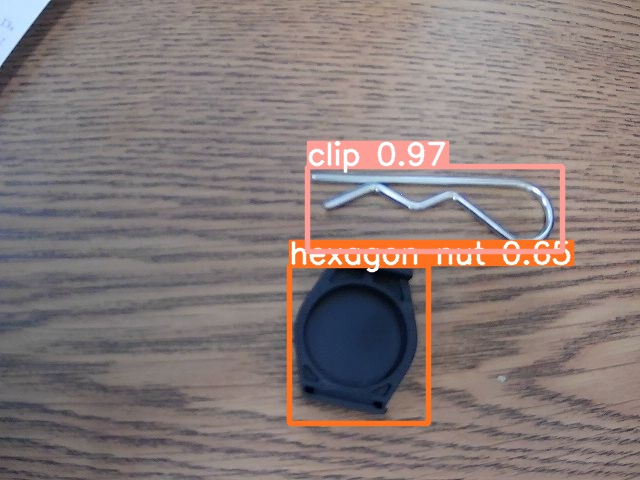



Image /content/runs/detect/predict3/photo_02.jpg



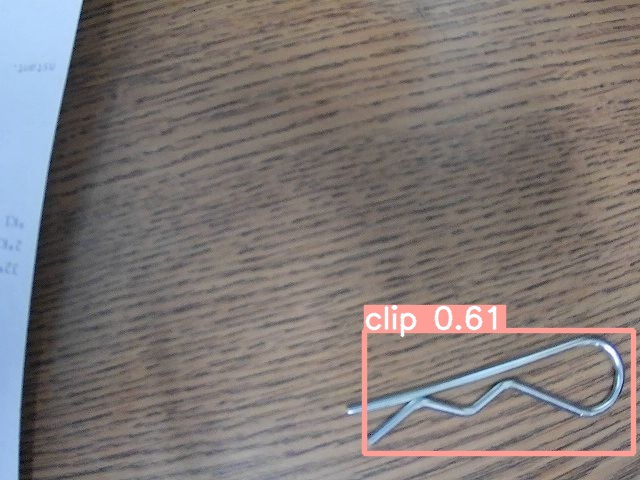



Image /content/runs/detect/predict3/photo_03.jpg



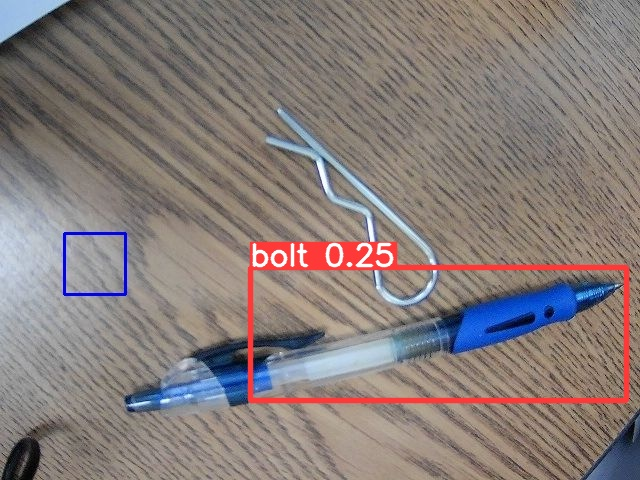

In [ ]:
## Display the detection results.
## Note: Pay attention to the log above, the results could be in a different directory.

import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict3/*.jpg')[:3]:
      print("Image " + image_path + "\n")
      display(Image(filename=image_path, width=600))
      print("\n")